If we think about the variables in this system there's only two. 

1. $g$ the size of the group that we allocate
2. $p$ the probability of somebody having the disease 

It turns out that we can define some quantities with just these two variables.

$$\mathbf{P}(\text{none positive in group}) = (1-p)^g$$

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pylab as plt 

g = np.linspace(1, 200, 200)
p = 0.99**g

In [2]:
pd.DataFrame({'g':g, 'p':p}).head(3)

,g,p
0,1.0,0.990000
1,2.0,0.980100
2,3.0,0.970299


Let's make a plot of this!

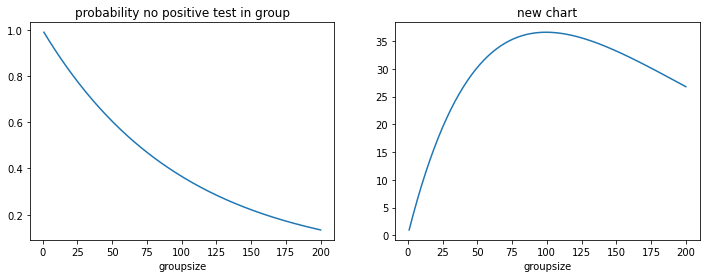

In [3]:
plt.figure(figsize=(12, 4))
plt.subplot(121)
plt.plot(g, p)
plt.xlabel("groupsize")
plt.title("probability no positive test in group")
plt.subplot(122)
plt.plot(g, p*g)
plt.xlabel("groupsize")
plt.title("new chart");

In [4]:
from ipywidgets import interact

import numpy as np
import matplotlib.pylab as plt

@interact(p=(0.001, 0.2, 0.001))
def f(p):
    g = np.linspace(1, 200, 500)
    prob_group_safe = (1-p)**g
    plt.figure(figsize=(12, 3))
    plt.plot(g, g*prob_group_safe, label=f"p={np.round(p, 3)}")
    plt.xlabel("number of people in a group")
    plt.ylabel("E(groups off the hook)")
    plt.legend();

interactive(children=(FloatSlider(value=0.1, description='p', max=0.2, min=0.001, step=0.001), Output()), _dom…

#### Does the relationship make sense?

If the probability of having the disease is low, then we can have larger groups. This makes sense. The odds of having a single person in the group who has the disease is smaller. This also holds vise versa. When the probability of having the disease is high then we cannot afford large groups. We'd need to re-test all over the place! 

#### What's next? 

There seems to be something interesting happening here. Notice that there's always a "tip" of a hill in our chart? We could argue that given a disease probability $p$ there's a value for $n$ where the peak occurs. This could be seen as an "optimal value". We could look for this value numerically. But there's also maths that we can use! 

In [5]:
import sympy as sp
g, p = sp.symbols("g, p")

exp = g * (1-p) ** g

exp

g*(1 - p)**g

In [6]:
sp.diff(exp, g)

g*(1 - p)**g*log(1 - p) + (1 - p)**g

In [7]:
sp.solve(sp.diff(exp, g), g)

[-1/log(1 - p)]

In [21]:
g_opt = -1/sp.log(1 - p)
g_opt.subs(p, 0.01).evalf()

99.4991624734221

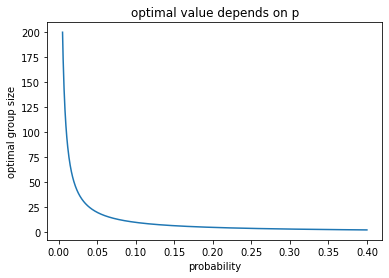

In [22]:
calc_n_groups = sp.lambdify(p, g_opt)

p_vals = np.linspace(0.005, .4, 1000)
n_vals = [calc_n_groups(_) for _ in p_vals]

plt.plot(p_vals, n_vals)
plt.xlabel("probability")
plt.ylabel("optimal group size")
plt.title("optimal value depends on p");

This is pretty interesting. But here's the big question... how many tests do we need?

In [23]:
calc_n_groups(0.01)

99.49916247342207

In [24]:
import random

def chunker(seq, size):
    return (seq[pos:pos + size] for pos in range(0, len(seq), size))

prob_disease = 0.01
population_size = 2_000_000
est_cases = int(prob_disease * population_size)
population = [{"i": i+1, "disease": True if random.random() < prob_disease else False} 
              for i in range(population_size)]

group_size = int(calc_n_groups(prob_disease))
n_tests = 0

In [25]:
np.mean([any([i['disease'] for i in chunk]) 
         for chunk in chunker(population, group_size)])

0.6313913775181904

In [26]:
potentially_positive_pop = []
for chunk in chunker(population, group_size):
    n_tests += 1
    if any([i['disease'] for i in chunk]):
        for member in chunk:
            potentially_positive_pop.append(member)

In [27]:
from pprint import pprint

pprint({"original population": population_size,
       "positive cases left": len(potentially_positive_pop),
       "n_tests used": n_tests, 
       "new probability": est_cases/len(potentially_positive_pop)})

{'n_tests used': 20203,
 'new probability': 0.015837268894653655,
 'original population': 2000000,
 'positive cases left': 1262844}


Let's now run this in a big way!

In [28]:
class Simulation:
    def __init__(self, prob_disease, population_size):
        self.prob_disease = prob_disease
        self.population_size = population_size
        self.est_cases = int(prob_disease * population_size)
        self.population = [{"i": i+1, "disease": True if random.random() < prob_disease else False} 
                            for i in range(population_size)]
        self.group_size = None
        self.n_tests = 0
        self.epoch = 0
        self.data = []
        self.log_state()
    
    def log_state(self):
        log = {
            'epoch': self.epoch,
            'pop': len(self.population),
            'cases': self.est_cases,
            'group_size': self.group_size,
            'n_tests': self.n_tests,
            'p': self.prob_disease
        }
        print(log)
        self.data.append(log)

    def handle_single_round(self):
        potentially_positive_pop = []
        self.group_size = int(calc_n_groups(self.prob_disease))
        for chunk in chunker(self.population, self.group_size):
            self.n_tests += 1
            if any([i['disease'] for i in chunk]):
                for member in chunk:
                    potentially_positive_pop.append(member)
        self.prob_disease = self.est_cases/len(potentially_positive_pop)
        self.population = potentially_positive_pop
        self.epoch += 1
        self.log_state()

In [29]:
s = Simulation(prob_disease=0.01, population_size=10_000_000)        
for i in range(3):
    s.handle_single_round()

{'epoch': 0, 'pop': 10000000, 'cases': 100000, 'group_size': None, 'n_tests': 0, 'p': 0.01}
{'epoch': 1, 'pop': 6304716, 'cases': 100000, 'group_size': 99, 'n_tests': 101011, 'p': 0.015861142674785035}
{'epoch': 2, 'pop': 4453768, 'cases': 100000, 'group_size': 62, 'n_tests': 202700, 'p': 0.02245289830992544}
{'epoch': 3, 'pop': 3294764, 'cases': 100000, 'group_size': 44, 'n_tests': 303922, 'p': 0.03035118752056293}
